In [1]:
import pandas as pd
import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Helper functions for the data processing
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    #print(big_string)
    return np.nan

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Mr', 'Master']:
        return -2
    elif title in ['Countess', 'Mme', 'Mrs']:
        return -1
    elif title in ['Mlle', 'Ms', 'Miss']:
        return 1
    elif title =='Dr':
        if x['Sex']=='female':
            return -1
        else:
            return -2
    else:
        return title 

#The data processing for the training and testing data sets
def data_train():
    train_data = pd.read_csv("train.csv")
    
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']

    train_data['Title'] = train_data['Name'].map(lambda x: substrings_in_string(x, title_list))   
    train_data['Title'] = train_data.apply(replace_titles, axis=1)
    train_data['Title'] = train_data['Title'].fillna(0)
    
    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    train_data['Cabin'] = train_data['Cabin'].astype(str)
    train_data['Deck'] = train_data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    train_data.loc[(train_data.Deck == 'A'),'Deck'] = -1
    train_data.loc[(train_data.Deck == 'B'),'Deck'] = -.75
    train_data.loc[(train_data.Deck == 'C'),'Deck'] = -.5
    train_data.loc[(train_data.Deck == 'D'),'Deck'] = -.25
    train_data.loc[(train_data.Deck == 'E'),'Deck'] = .25
    train_data.loc[(train_data.Deck == 'F'),'Deck'] = .5
    train_data.loc[(train_data.Deck == 'T'),'Deck'] = .75
    train_data.loc[(train_data.Deck == 'G'),'Deck'] = 1
    train_data['Deck'] = train_data['Deck'].fillna(1.5)
    
    #Creating new family_size column
    train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch']
    
    train_data['Family_Size*class'] = train_data['Family_Size'] + train_data['Pclass']
    
    train_data.loc[(train_data.Pclass == 1),'Pclass'] = 1
    train_data.loc[(train_data.Pclass == 2),'Pclass'] = .5
    train_data.loc[(train_data.Pclass == 3),'Pclass'] = -1
    
    age_mean = train_data['Age'].mean(skipna = True)
    train_data['Age'] = train_data['Age'].fillna(age_mean)
    
    train_data['Minor'] = train_data['Age']
    train_data.loc[(train_data.Minor <= 16),'Minor'] = 1
    train_data.loc[(train_data.Minor > 16),'Minor'] = 0
    
    train_data['Age*Class'] = train_data['Age'] + train_data['Pclass']
    
    train_data['Fare_Per_Person'] = train_data['Fare']  / (train_data['Family_Size']+1)

    train_data.loc[(train_data.Sex == 'female'),'Sex'] = -1
    train_data.loc[(train_data.Sex == 'male'),'Sex'] = 1

    train_data.loc[(train_data.Embarked == 'C'),'Embarked'] = -1
    train_data.loc[(train_data.Embarked == 'Q'),'Embarked'] = 1
    train_data.loc[(train_data.Embarked == 'S'),'Embarked'] = 2
    train_data['Embarked'] = train_data['Embarked'].fillna(-2)
    
    train_data['Sex*Class'] = train_data['Sex'] + train_data['Pclass']
    
    train_data['Age*Class'] = train_data['Age*Class'].fillna(-1)
    
    train_data['Embarked*Class'] = train_data['Embarked'] * train_data['Pclass']
    
    train_data['Minor*Class'] = train_data['Minor'] + train_data['Pclass']
    
    train_data['Age*Deck'] = train_data['Age'] + train_data['Deck']
    
    #train_data["Embarked*Class"] = train_data["Embarked*Class"].fillna(0)
    
    train_data['Title*Class'] = train_data['Title'] + train_data['Pclass']

    tmp = train_data[['Pclass', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Title*Class', 'Minor', 'Minor*Class',
                      'Family_Size', 'Age*Class', 'Fare_Per_Person', 'Embarked*Class', 'Sex*Class', 'Age*Deck', 'Family_Size*class']].copy()
    
    X = pd.DataFrame(tmp).to_numpy()
    X = X.T
    Y = np.array([train_data['Survived'].values])

    X = np.float32(X)
    Y = np.float32(Y)
    m = X.shape[1]  
    #Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuff_X = X[:, permutation]
    shuff_Y = Y[:, permutation].reshape((1,m))

    devM = round(m * .2)
    devM2 = m - devM
    
    train_X = shuff_X[:, 0:(devM2)]
    train_Y = shuff_Y[:, 0:(devM2)]
    dev_X = shuff_X[:, -(devM + 1):-1]
    dev_Y = shuff_Y[:, -(devM + 1):-1]
    
    m_train = train_X.shape[1]
    m_test = dev_X.shape[1]
    
    print ("Number of training examples: m_train = " + str(m_train))
    print ("Number of testing examples: m_test = " + str(m_test))
    print ("train_set_x shape: " + str(train_X.shape))
    print ("train_set_y shape: " + str(train_Y.shape))
    print ("test_set_x shape: " + str(dev_X.shape))
    print ("test_set_y shape: " + str(dev_Y.shape))
    
    return train_X, train_Y, dev_X, dev_Y

#The data processing for the submission data sets
def data_test():
    test_data = pd.read_csv("test.csv")
    
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                        'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                        'Don', 'Jonkheer']

    test_data['Title'] = test_data['Name'].map(lambda x: substrings_in_string(x, title_list))   
    test_data['Title'] = test_data.apply(replace_titles, axis=1)
    test_data['Title'] = test_data['Title'].fillna(0)
    
    #Creating new family_size column
    test_data['Family_Size'] = test_data['SibSp'] + test_data['Parch']
    test_data['Family_Size*class'] = test_data['Family_Size'] + test_data['Pclass']
    
    #Turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    test_data['Cabin'] = test_data['Cabin'].astype(str)
    test_data['Deck'] = test_data['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    
    test_data.loc[(test_data.Deck == 'A'),'Deck'] = -1
    test_data.loc[(test_data.Deck == 'B'),'Deck'] = -.75
    test_data.loc[(test_data.Deck == 'C'),'Deck'] = -.5
    test_data.loc[(test_data.Deck == 'D'),'Deck'] = -.25
    test_data.loc[(test_data.Deck == 'E'),'Deck'] = .25
    test_data.loc[(test_data.Deck == 'F'),'Deck'] = .5
    test_data.loc[(test_data.Deck == 'T'),'Deck'] = .75
    test_data.loc[(test_data.Deck == 'G'),'Deck'] = 1
    test_data['Deck'] = test_data['Deck'].fillna(1.5)
    
    test_data.loc[test_data['Age'] <= 16, 'Minor'] = 1
    test_data.loc[test_data['Age'] > 16, 'Minor'] = 0
    
    test_data.loc[(test_data.Pclass == 1),'Pclass'] = 1
    test_data.loc[(test_data.Pclass == 2),'Pclass'] = .5
    test_data.loc[(test_data.Pclass == 3),'Pclass'] = -1
    
    age_mean = test_data["Age"].mean(skipna = True)
    test_data["Age"] = test_data["Age"].fillna(age_mean)
    
    test_data['Minor'] = test_data['Age']
    test_data.loc[(test_data.Minor <= 16),'Minor'] = 1
    test_data.loc[(test_data.Minor > 16),'Minor'] = 0
    
    test_data['Age*Class'] = test_data['Age'] + test_data['Pclass']
    
    test_data['Fare_Per_Person'] = test_data['Fare']  / (test_data['Family_Size']+1)

    test_data.loc[(test_data.Sex == 'female'),'Sex'] = -1
    test_data.loc[(test_data.Sex == 'male'),'Sex'] = 1

    test_data.loc[(test_data.Embarked == 'C'),'Embarked'] = -1
    test_data.loc[(test_data.Embarked == 'Q'),'Embarked'] = 1
    test_data.loc[(test_data.Embarked == 'S'),'Embarked'] = 2
    test_data["Embarked"] = test_data["Embarked"].fillna(-2)
    
    test_data['Sex*Class'] = test_data['Sex'] + test_data['Pclass']
    
    test_data["Age*Class"] = test_data["Age*Class"].fillna(-1)
    
    test_data['Minor*Class'] = test_data['Minor'] + test_data['Pclass']
    
    test_data['Embarked*Class'] = test_data['Embarked'] + test_data['Pclass']
    
    test_data['Age*Deck'] = test_data['Age'] + test_data['Deck']
    
    #test_data["Embarked*Class"] = test_data["Embarked*Class"].fillna(0)
    
    test_data['Title*Class'] = test_data['Title'] + test_data['Pclass']

    tmp = test_data[['Pclass', 'Title', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Title*Class', 'Minor', 'Minor*Class',
                      'Family_Size', 'Age*Class', 'Fare_Per_Person', 'Embarked*Class', 'Sex*Class', 'Age*Deck', 'Family_Size*class']].copy()
    
    X = pd.DataFrame(tmp).to_numpy()
    X = X.T

    X = np.float32(X)
    
    test = X[:, :]
    
    return test

In [9]:
train_X, train_Y, dev_X, dev_Y = data_train()
activation = 'relu'
optimizer = keras.optimizers.Adam(0.0005)
l = 0.007

model = models.Sequential()
model.add(layers.Dense(256, activation=activation, input_shape=(19,)))
model.add(layers.Dense(128, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(64, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(32, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(16, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(8, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(4, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(2, activation=activation, kernel_regularizer=keras.regularizers.l2(l=l)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_X.T, train_Y.T,
                    epochs=500,
                    batch_size=256,
                    validation_data=(dev_X.T, dev_Y.T))

Number of training examples: m_train = 713
Number of testing examples: m_test = 178
train_set_x shape: (19, 713)
train_set_y shape: (1, 713)
test_set_x shape: (19, 178)
test_set_y shape: (1, 178)
Train on 713 samples, validate on 178 samples
Epoch 1/500
713/713 [==============================] - 1s 752us/step - loss: 3.0819 - accuracy: 0.6129 - val_loss: 3.0254 - val_accuracy: 0.6348
Epoch 2/500
713/713 [==============================] - 0s 64us/step - loss: 3.0041 - accuracy: 0.6129 - val_loss: 2.9562 - val_accuracy: 0.6348
Epoch 3/500
713/713 [==============================] - 0s 59us/step - loss: 2.9349 - accuracy: 0.6129 - val_loss: 2.8900 - val_accuracy: 0.6348
Epoch 4/500
713/713 [==============================] - 0s 50us/step - loss: 2.8691 - accuracy: 0.6129 - val_loss: 2.8261 - val_accuracy: 0.6348
Epoch 5/500
713/713 [==============================] - 0s 51us/step - loss: 2.8065 - accuracy: 0.6129 - val_loss: 2.7650 - val_accuracy: 0.6348
Epoch 6/500
713/713 [================

Epoch 56/500
713/713 [==============================] - 0s 48us/step - loss: 1.1762 - accuracy: 0.7966 - val_loss: 1.2516 - val_accuracy: 0.7472
Epoch 57/500
713/713 [==============================] - 0s 47us/step - loss: 1.1612 - accuracy: 0.8036 - val_loss: 1.2380 - val_accuracy: 0.7416
Epoch 58/500
713/713 [==============================] - 0s 48us/step - loss: 1.1475 - accuracy: 0.8036 - val_loss: 1.2367 - val_accuracy: 0.7135
Epoch 59/500
713/713 [==============================] - 0s 48us/step - loss: 1.1375 - accuracy: 0.7994 - val_loss: 1.2053 - val_accuracy: 0.7584
Epoch 60/500
713/713 [==============================] - 0s 49us/step - loss: 1.1259 - accuracy: 0.8050 - val_loss: 1.2235 - val_accuracy: 0.7191
Epoch 61/500
713/713 [==============================] - 0s 50us/step - loss: 1.1151 - accuracy: 0.7924 - val_loss: 1.1954 - val_accuracy: 0.7472
Epoch 62/500
713/713 [==============================] - 0s 47us/step - loss: 1.1040 - accuracy: 0.8008 - val_loss: 1.1871 - val_ac

713/713 [==============================] - 0s 47us/step - loss: 0.7915 - accuracy: 0.8303 - val_loss: 0.9068 - val_accuracy: 0.7472
Epoch 113/500
713/713 [==============================] - 0s 46us/step - loss: 0.7986 - accuracy: 0.8149 - val_loss: 0.8835 - val_accuracy: 0.7809
Epoch 114/500
713/713 [==============================] - 0s 47us/step - loss: 0.7918 - accuracy: 0.8387 - val_loss: 0.8997 - val_accuracy: 0.7528
Epoch 115/500
713/713 [==============================] - 0s 49us/step - loss: 0.7895 - accuracy: 0.8233 - val_loss: 0.8942 - val_accuracy: 0.7416
Epoch 116/500
713/713 [==============================] - 0s 48us/step - loss: 0.7842 - accuracy: 0.8219 - val_loss: 0.8866 - val_accuracy: 0.7640
Epoch 117/500
713/713 [==============================] - 0s 49us/step - loss: 0.7764 - accuracy: 0.8121 - val_loss: 0.9114 - val_accuracy: 0.7303
Epoch 118/500
713/713 [==============================] - 0s 48us/step - loss: 0.7753 - accuracy: 0.8373 - val_loss: 0.8632 - val_accuracy:

713/713 [==============================] - 0s 48us/step - loss: 0.6629 - accuracy: 0.8429 - val_loss: 0.7706 - val_accuracy: 0.7921
Epoch 169/500
713/713 [==============================] - 0s 47us/step - loss: 0.6653 - accuracy: 0.8373 - val_loss: 0.8052 - val_accuracy: 0.7528
Epoch 170/500
713/713 [==============================] - 0s 45us/step - loss: 0.6632 - accuracy: 0.8331 - val_loss: 0.7944 - val_accuracy: 0.7640
Epoch 171/500
713/713 [==============================] - 0s 47us/step - loss: 0.6613 - accuracy: 0.8373 - val_loss: 0.7680 - val_accuracy: 0.7921
Epoch 172/500
713/713 [==============================] - 0s 47us/step - loss: 0.6588 - accuracy: 0.8345 - val_loss: 0.7978 - val_accuracy: 0.7528
Epoch 173/500
713/713 [==============================] - 0s 46us/step - loss: 0.6575 - accuracy: 0.8359 - val_loss: 0.7669 - val_accuracy: 0.7865
Epoch 174/500
713/713 [==============================] - 0s 47us/step - loss: 0.6551 - accuracy: 0.8373 - val_loss: 0.7897 - val_accuracy:

713/713 [==============================] - 0s 50us/step - loss: 0.6046 - accuracy: 0.8527 - val_loss: 0.7327 - val_accuracy: 0.7640
Epoch 225/500
713/713 [==============================] - 0s 51us/step - loss: 0.5995 - accuracy: 0.8583 - val_loss: 0.7423 - val_accuracy: 0.7697
Epoch 226/500
713/713 [==============================] - 0s 49us/step - loss: 0.6000 - accuracy: 0.8485 - val_loss: 0.7254 - val_accuracy: 0.7865
Epoch 227/500
713/713 [==============================] - 0s 47us/step - loss: 0.5994 - accuracy: 0.8471 - val_loss: 0.7416 - val_accuracy: 0.7697
Epoch 228/500
713/713 [==============================] - 0s 47us/step - loss: 0.6014 - accuracy: 0.8471 - val_loss: 0.7568 - val_accuracy: 0.7584
Epoch 229/500
713/713 [==============================] - 0s 46us/step - loss: 0.5979 - accuracy: 0.8513 - val_loss: 0.7412 - val_accuracy: 0.7640
Epoch 230/500
713/713 [==============================] - 0s 46us/step - loss: 0.5941 - accuracy: 0.8499 - val_loss: 0.7280 - val_accuracy:

713/713 [==============================] - 0s 47us/step - loss: 0.5805 - accuracy: 0.8387 - val_loss: 0.6958 - val_accuracy: 0.7921
Epoch 281/500
713/713 [==============================] - 0s 52us/step - loss: 0.5777 - accuracy: 0.8499 - val_loss: 0.7493 - val_accuracy: 0.7640
Epoch 282/500
713/713 [==============================] - 0s 50us/step - loss: 0.5672 - accuracy: 0.8612 - val_loss: 0.6880 - val_accuracy: 0.8146
Epoch 283/500
713/713 [==============================] - 0s 51us/step - loss: 0.5670 - accuracy: 0.8513 - val_loss: 0.7728 - val_accuracy: 0.7584
Epoch 284/500
713/713 [==============================] - 0s 47us/step - loss: 0.5714 - accuracy: 0.8527 - val_loss: 0.6950 - val_accuracy: 0.7921
Epoch 285/500
713/713 [==============================] - 0s 47us/step - loss: 0.5683 - accuracy: 0.8485 - val_loss: 0.7358 - val_accuracy: 0.7753
Epoch 286/500
713/713 [==============================] - 0s 47us/step - loss: 0.5729 - accuracy: 0.8527 - val_loss: 0.6901 - val_accuracy:

713/713 [==============================] - 0s 53us/step - loss: 0.5503 - accuracy: 0.8555 - val_loss: 0.7010 - val_accuracy: 0.7697
Epoch 337/500
713/713 [==============================] - 0s 60us/step - loss: 0.5430 - accuracy: 0.8626 - val_loss: 0.6826 - val_accuracy: 0.7865
Epoch 338/500
713/713 [==============================] - 0s 50us/step - loss: 0.5465 - accuracy: 0.8471 - val_loss: 0.7280 - val_accuracy: 0.7640
Epoch 339/500
713/713 [==============================] - 0s 52us/step - loss: 0.5424 - accuracy: 0.8583 - val_loss: 0.6731 - val_accuracy: 0.8034
Epoch 340/500
713/713 [==============================] - 0s 55us/step - loss: 0.5516 - accuracy: 0.8485 - val_loss: 0.7145 - val_accuracy: 0.7640
Epoch 341/500
713/713 [==============================] - 0s 79us/step - loss: 0.5398 - accuracy: 0.8597 - val_loss: 0.6780 - val_accuracy: 0.8034
Epoch 342/500
713/713 [==============================] - 0s 79us/step - loss: 0.5425 - accuracy: 0.8654 - val_loss: 0.7161 - val_accuracy:

713/713 [==============================] - 0s 46us/step - loss: 0.5344 - accuracy: 0.8612 - val_loss: 0.6892 - val_accuracy: 0.7753
Epoch 393/500
713/713 [==============================] - 0s 47us/step - loss: 0.5259 - accuracy: 0.8597 - val_loss: 0.6861 - val_accuracy: 0.7697
Epoch 394/500
713/713 [==============================] - 0s 47us/step - loss: 0.5236 - accuracy: 0.8597 - val_loss: 0.7091 - val_accuracy: 0.7640
Epoch 395/500
713/713 [==============================] - 0s 46us/step - loss: 0.5277 - accuracy: 0.8583 - val_loss: 0.6922 - val_accuracy: 0.7753
Epoch 396/500
713/713 [==============================] - 0s 47us/step - loss: 0.5279 - accuracy: 0.8696 - val_loss: 0.6847 - val_accuracy: 0.7753
Epoch 397/500
713/713 [==============================] - 0s 48us/step - loss: 0.5410 - accuracy: 0.8499 - val_loss: 0.6873 - val_accuracy: 0.7753
Epoch 398/500
713/713 [==============================] - 0s 47us/step - loss: 0.5390 - accuracy: 0.8555 - val_loss: 0.6972 - val_accuracy:

713/713 [==============================] - 0s 49us/step - loss: 0.5162 - accuracy: 0.8626 - val_loss: 0.6671 - val_accuracy: 0.7809
Epoch 449/500
713/713 [==============================] - 0s 47us/step - loss: 0.5111 - accuracy: 0.8640 - val_loss: 0.7112 - val_accuracy: 0.7697
Epoch 450/500
713/713 [==============================] - 0s 45us/step - loss: 0.5203 - accuracy: 0.8640 - val_loss: 0.6552 - val_accuracy: 0.7978
Epoch 451/500
713/713 [==============================] - 0s 45us/step - loss: 0.5152 - accuracy: 0.8696 - val_loss: 0.6881 - val_accuracy: 0.7753
Epoch 452/500
713/713 [==============================] - 0s 45us/step - loss: 0.5096 - accuracy: 0.8668 - val_loss: 0.6847 - val_accuracy: 0.7753
Epoch 453/500
713/713 [==============================] - 0s 45us/step - loss: 0.5083 - accuracy: 0.8668 - val_loss: 0.6867 - val_accuracy: 0.7753
Epoch 454/500
713/713 [==============================] - 0s 45us/step - loss: 0.5091 - accuracy: 0.8597 - val_loss: 0.6779 - val_accuracy:

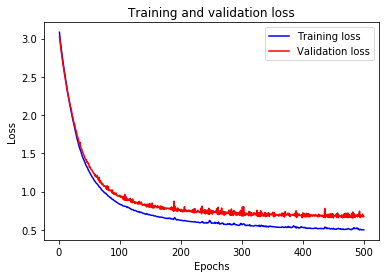

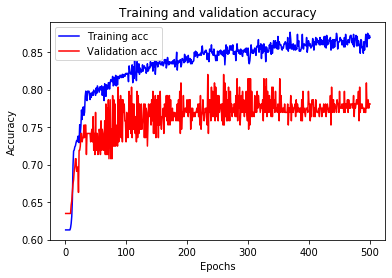

In [10]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss') 
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_dict['accuracy'] 
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc') 
plt.plot(epochs, val_acc, 'r', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.legend()
plt.show()

In [6]:
# make class predictions with the model
predictions = model.predict_classes(dev_X.T)
#for i in range(dev_X.shape[1]):
#    if predictions[i] != dev_Y.T[i]:
#        print('%s => %d (expected %d)' % (dev_X.T[i].tolist(), predictions[i], dev_Y.T[i]))

test_X = data_test()
predict = model.predict_classes(test_X.T)
predictions = predict.tolist()
test_data = pd.read_csv("test.csv")
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output['Survived'] = output['Survived'].str.get(0)
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

# load model
#model = load_model('model.h5')
# summarize model.
#model.summary()
model.save("model_titanic.h5")
print("Saved model to disk")

Your submission was successfully saved!
Saved model to disk
